In [150]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import ensemble
%matplotlib inline

Прочитаем датасет и выполним его препроцессинг:

In [151]:
data = pd.read_csv("dataset.csv")

# бинарные признаки
data["housing"] = data["housing"] == "yes"
data["loan"] = data["loan"] == "yes"
data["y"] = data["y"] == "yes"

# Категориальные признаки
data["job"] = data["job"].astype("category")
data["marital"] = data["marital"].astype("category")
data["education"] = data["education"].astype("category")
data["contact"] = data["contact"].astype("category")
data["month"] = data["month"].astype("category")

data = data.drop(["default"], axis = 1)
data = data.drop(["poutcome"], axis = 1)
data = data.replace("unknown", np.NaN)

# Заполнение модой пропущенных значений
data["job"].fillna(data["job"].mode().iloc[0], inplace = True)
data["education"].fillna(data["education"].mode().iloc[0], inplace = True)
data["contact"].fillna(data["contact"].mode().iloc[0], inplace = True)

numerical_columns = [c for c in data.columns if data[c].dtype.name == 'int64']

## Обработка категориальных значений

Для обработки категориальных признаков **job**, **marital**, **education**, **month** будем использовать бинаризацию:

In [152]:
categorial_table = pd.concat((pd.get_dummies(data['job']), pd.get_dummies(data['marital']), pd.get_dummies(data['month'])), axis = 1)
categorial_table.head()

,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Обработка бинарных значений

Бинарные признаки **housing**, **loan**, **y** заменим на числовые:

In [153]:
data['housing'] = pd.factorize(data['housing'])[0]
data['loan'] = pd.factorize(data['loan'])[0]
data['y'] = pd.factorize(data['y'])[0]

bin_table=pd.concat((data['housing'], data['loan'], data['y']), axis = 1)
bin_table.head()

,housing,loan,y
0,0,0,0
1,0,0,0
2,0,1,0
3,0,0,0
4,1,0,0


## Нормализация количественных признаков

Стандартизуем количественные признаки:

In [154]:
data_num_stand = (data[numerical_columns] - data[numerical_columns].mean(axis = 0)) / data[numerical_columns].std(axis = 0)
data_num_stand.head()

,age,balance,day,duration,campaign,pdays,previous
0,1.606947,0.256416,-1.298462,0.011016,-0.569344,-0.411449,-0.251938
1,0.288526,-0.437890,-1.298462,-0.416122,-0.569344,-0.411449,-0.251938
2,-0.747376,-0.446758,-1.298462,-0.707353,-0.569344,-0.411449,-0.251938
3,0.571045,0.047205,-1.298462,-0.645224,-0.569344,-0.411449,-0.251938
4,-0.747376,-0.447086,-1.298462,-0.233618,-0.569344,-0.411449,-0.251938


In [155]:
data_num_stand.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04,4.521100e+04
mean,2.135579e-16,-4.067535e-16,-3.063960e-14,-5.313654e-17,1.723756e-14,1.057063e-13,-1.007183e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.159970e+00,-3.081114e+00,-1.779088e+00,-1.002467e+00,-5.693443e-01,-4.114486e-01,-2.519376e-01
25%,-7.473762e-01,-4.237673e-01,-9.379923e-01,-6.025100e-01,-5.693443e-01,-4.114486e-01,-2.519376e-01
50%,-1.823386e-01,-3.002766e-01,2.326005e-02,-3.035132e-01,-2.465576e-01,-4.114486e-01,-2.519376e-01
75%,6.652178e-01,2.158719e-02,6.240428e-01,2.362344e-01,7.622910e-02,-4.114486e-01,-2.519376e-01
max,5.091346e+00,3.309441e+01,1.825608e+00,1.809450e+01,1.944343e+01,8.297339e+00,1.191347e+02


## Формирование выборок

Объединим обработанные данные в одну таблицу:

In [156]:
data_stand = pd.concat((data_num_stand, bin_table, categorial_table), axis = 1)
data_stand.head()

,age,balance,day,duration,campaign,pdays,previous,housing,loan,y,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,1.606947,0.256416,-1.298462,0.011016,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.288526,-0.437890,-1.298462,-0.416122,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.747376,-0.446758,-1.298462,-0.707353,-0.569344,-0.411449,-0.251938,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.571045,0.047205,-1.298462,-0.645224,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,-0.747376,-0.447086,-1.298462,-0.233618,-0.569344,-0.411449,-0.251938,1,0,0,...,0,0,0,0,0,0,1,0,0,0


Поскольку ранее было принято решение избавиться от признака, характеризующего успех предыдущих маркетинговых кампаний, удалим из итоговой таблицы признаки **pdays** и **previous**.

In [157]:
y = data_stand['y']
X = data_stand.drop(['pdays', 'previous','y'], axis = 1)
X.head()

,age,balance,day,duration,campaign,housing,loan,admin.,blue-collar,entrepreneur,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,1.606947,0.256416,-1.298462,0.011016,-0.569344,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.288526,-0.437890,-1.298462,-0.416122,-0.569344,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.747376,-0.446758,-1.298462,-0.707353,-0.569344,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0.571045,0.047205,-1.298462,-0.645224,-0.569344,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,-0.747376,-0.447086,-1.298462,-0.233618,-0.569344,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


Данные для обучения и тестирования разобьем в соотношении 4:1.

In [158]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

36168 9043


## Обучение MLPClassifier

Построим классификатор с одним скрытым слоем и натренируем его

In [159]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes = (1,),
                          solver = 'lbfgs', 
                          activation = 'relu',
                          random_state = 24,
                          max_iter=2000)
mlp_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(1,), max_iter=2000, random_state=24,
              solver='lbfgs')

Ошибка на обучающей и тестовой выборках:

In [160]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(0.10628179606281796, 0.10870286409377419)

Далее натренируем классификатор с двумя скрытыми слоями:

In [161]:
mlp_model = MLPClassifier(hidden_layer_sizes = (2,),
                          solver = 'lbfgs', 
                          activation = 'relu',
                          random_state = 24,
                          max_iter=2000)
mlp_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(2,), max_iter=2000, random_state=24,
              solver='lbfgs')

Ошибка на обучающей и тестовой выборках:

In [162]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(0.10431873479318735, 0.1070441225257105)

### Зависимость ошибки от параметра alpha

In [163]:
alpha_arr = np.logspace(-4, 3, 50)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(hidden_layer_sizes = (2,),
                          solver = 'lbfgs', 
                          activation = 'relu',
                          random_state = 24,
                          max_iter=2000,
                          alpha = alpha)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

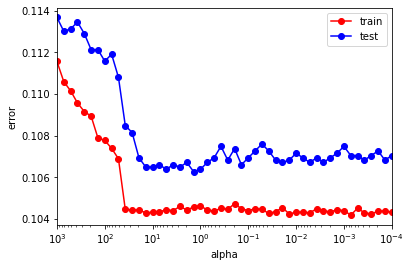

In [164]:
plt.semilogx(alpha_arr, train_err, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'b-o', label = 'test')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])

plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

Видно, что при значении alpha > 50 происходит недообучение, поскольку наблюдается большая ошибка как на обучающей, так и на тестовой выборке. Выведем минимальное значение ошибки и оптимальное значение alpha:

In [166]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

0.1041804910418049 0.10627004312728076
[1.38949549]


### Зависимость ошибки от количества нейронов в скрытом слое

In [167]:
neuron_numbers = np.array([5, 8, 10, 12, 15, 20, 25, 30, 40, 50, 70, 100])
test_err = []
train_err = []
for neuron_number in neuron_numbers:
    mlp_model = MLPClassifier(hidden_layer_sizes = (2, neuron_number),
                          solver = 'lbfgs', 
                          activation = 'relu',
                          random_state = 22,
                          max_iter=2000,
                          alpha = alpha_opt)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

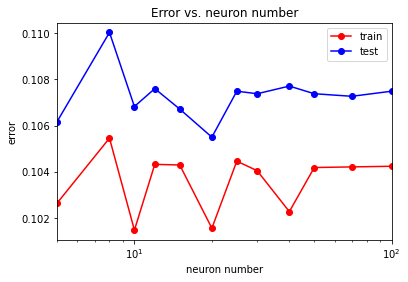

In [168]:
plt.semilogx(neuron_numbers, train_err, 'r-o', label = 'train')
plt.semilogx(neuron_numbers, test_err, 'b-o', label = 'test')
plt.xlim([np.min(neuron_numbers), np.max(neuron_numbers)])

plt.title('Error vs. neuron number')
plt.xlabel('neuron number')
plt.ylabel('error')
plt.legend()
pass

Видно, что при количестве нейронов в скрых слоях, меньшем 100, наблюдаются колебания на тестовой и обучающей выборках  
Минимальное значение ошибки и оптимальное количество нейронов в скрытом слое:

In [169]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

neuron_num_opt = neuron_numbers[test_err == min_test_err]
print(neuron_num_opt)

0.10147091351470913 0.10549596372885105
[20]


### Зависимость ошибки от количества скрытых слоёв

In [173]:
layer_numbers = np.array([1, 2, 3, 5, 10, 15])
test_err = []
train_err = []
for ln in layer_numbers:
    mlp_model = MLPClassifier(hidden_layer_sizes = (ln, neuron_num_opt[0]),
                          solver = 'lbfgs', 
                          activation = 'relu',
                          random_state = 22,
                          max_iter=5000,
                          alpha = alpha_opt)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

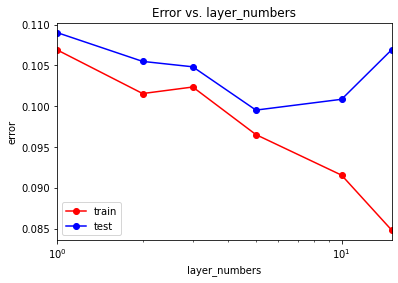

In [174]:
plt.semilogx(layer_numbers, train_err, 'r-o', label = 'train')
plt.semilogx(layer_numbers, test_err, 'b-o', label = 'test')
plt.xlim([np.min(layer_numbers), np.max(layer_numbers)])

plt.title('Error vs. layer_numbers')
plt.xlabel('layer_numbers')
plt.ylabel('error')
plt.legend()
pass

Из построенного графика видно, что количестве скрытых слоёв, больших 5, наблюдается переобучение, поскольку ошибка на обучающей выборке уменьшается, а на тестовой - увеличивается. Оптимальное количество скрытых слоев и ошибка на тестовой и обучающей выборках при данном значении параметра:

In [175]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

layer_number_opt = layer_numbers[test_err == min_test_err]
print(layer_number_opt)

0.08479871709798717 0.09952449408382175
[5]


### Выводы

В данной работе были проделаны эксперименты с MLP классификатором. Эксперементальным путем были подобраны параметр alpha, количество скрытых слоёв и количество нейронов в скрытом слое. Полученные данные были проанализированы на предмет выявления переобучения и недообучения при некоторых значениях параметров